In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import mahotas
import h5py
filedir = 'slides/'


/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data exploration - glass 3 only

In [2]:
filename = filedir+'glass3.hdf5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
print(len(data))

Keys: KeysView(<HDF5 file "glass3.hdf5" (mode r)>)
1965


Have a look at the first few images and their corresponding histograms

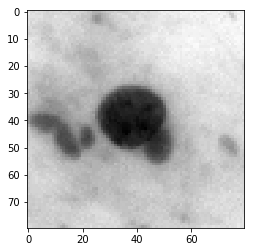

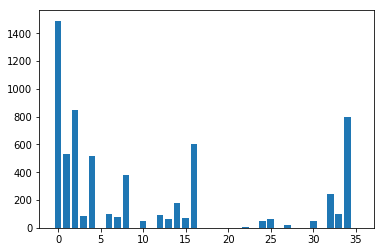

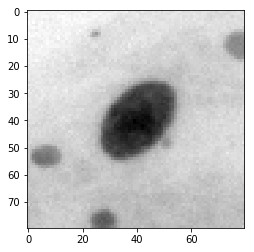

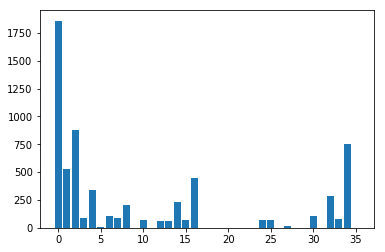

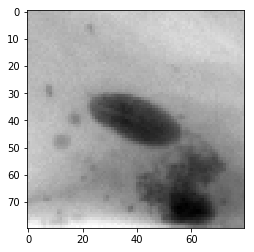

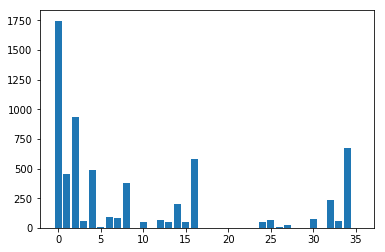

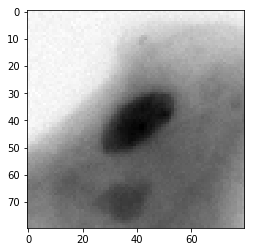

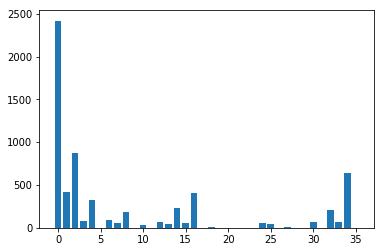

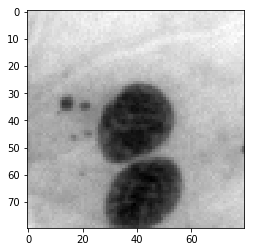

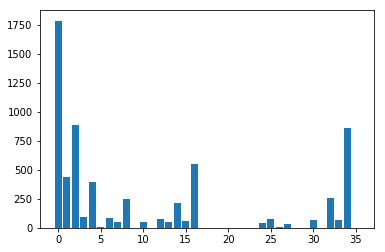

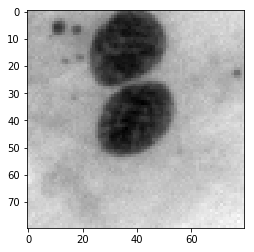

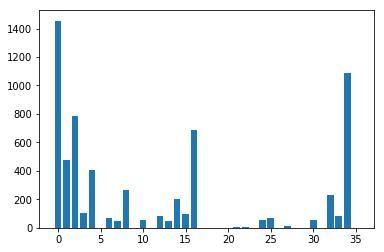

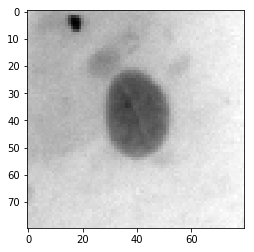

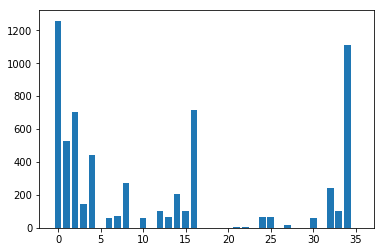

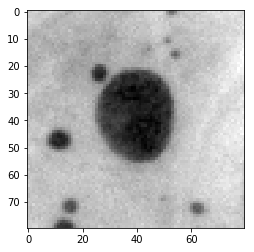

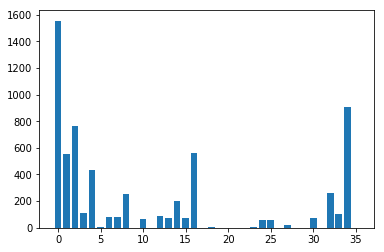

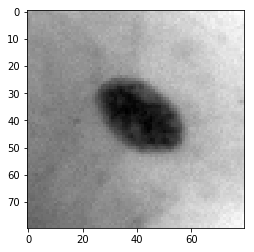

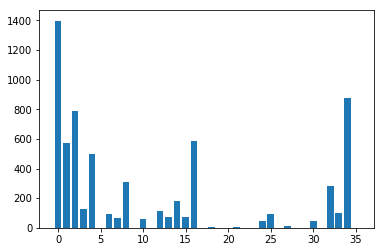

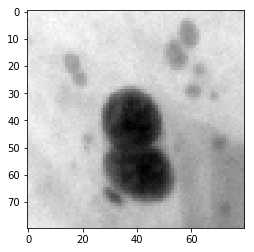

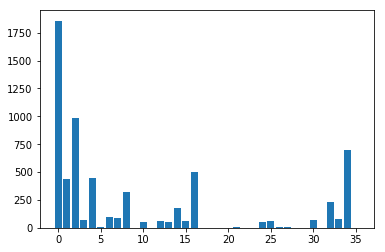

In [3]:
for i in range(10):
    plt.imshow(data[i][0], cmap='gray')
    plt.show()
    lbp=mahotas.features.lbp(data[i][0], 1, 8, ignore_zeros=False)
    plt.bar(np.arange(len(lbp)), lbp)
    plt.show()

## Extract Local Binary Patterns and train a neural network to recognise them

First get the data, in the three separate folds. Only load the training data for now but identify the testing folds as well

In [4]:
fold1tr=[[3,4,5,6],[37,38,12]]
fold2tr=[[3,4,5,6],[36,37,38]]
fold3tr=[[3,4,5,6],[12,36]]
fold1te=[[7,8],[36]]
fold2te=[[7,8],[12]]
fold3te=[[7,8],[37,38]]

Load fold1 training data

In [5]:
data_fold1_tr=[]
labels_fold1_tr=[]
for g in fold1tr[0]:
    filename = filedir+'glass'+str(g)+'.hdf5'
    f = h5py.File(filename, 'r')

    a_group_key = list(f.keys())[0]
    d=list(f[a_group_key])
    data_fold1_tr += d
    labels_fold1_tr += list(np.zeros(len(d)))
for g in fold1tr[1]:
    filename = filedir+'glass'+str(g)+'.hdf5'
    f = h5py.File(filename, 'r')

    a_group_key = list(f.keys())[0]
    d=list(f[a_group_key])
    data_fold1_tr += d
    labels_fold1_tr += list(np.ones(len(d)))

__LBP parameters__

In [6]:
LBP_P = 8
LBP_R = 1

In [7]:
#Mahotas returns all 36 rotation invariant patterns. We want to only use the uniform ones
#and take the non-uniform ones as a single data point.

#Take pattern histograms and combine patterns as proposed in Ojala et al 2002
#Uniform patterns 0-P map to 0-P and all others map to P+1.
#Hist is an array of histograms, each element is an array of pattern counts for a particular image
def combinePatterns(hist, P):
    ret=[list(hist[i][0:(P+1)])+[sum(hist[i][(P+1):])] for i in range(len(hist))]
    return ret

Take a look at what the mahotas LBP output looks like

In [8]:
mahotas.features.lbp(data_fold1_tr[0][0], LBP_R, LBP_P, ignore_zeros=False)

array([1.49e+03, 5.31e+02, 8.50e+02, 8.40e+01, 5.20e+02, 2.00e+00,
       9.60e+01, 7.80e+01, 3.77e+02, 0.00e+00, 4.80e+01, 0.00e+00,
       9.00e+01, 6.00e+01, 1.82e+02, 6.80e+01, 6.04e+02, 0.00e+00,
       2.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 3.00e+00, 0.00e+00,
       4.80e+01, 6.30e+01, 0.00e+00, 2.00e+01, 0.00e+00, 0.00e+00,
       4.70e+01, 0.00e+00, 2.40e+02, 9.80e+01, 7.98e+02, 0.00e+00])

In [9]:
#trying a function that is supposed to exist but doesnt
#mahotas.features.lbp_transform(data2[0][0], LBP_R, LBP_P, ignore_zeros=False)

For each sample, calculate the LBP histogram (normalised) and combine into the uniform / non-uniform patterns

In [10]:
nSamples=len(labels_fold1_tr)
nPixels=1
for a in data_fold1_tr[0].shape:
    nPixels *= a 

lbp_fold1_tr=[]
for i in range(nSamples):
    lbp_fold1_tr.append(mahotas.features.lbp(data_fold1_tr[i][0], LBP_R, LBP_P, ignore_zeros=False)/nPixels)

lbp_fold1_tr=combinePatterns(lbp_fold1_tr, LBP_P)

nBins=len(lbp_fold1_tr[0])
lbp_fold1_tr=np.array(lbp_fold1_tr).reshape((nSamples,nBins))

Split the training data into training and validation sets

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lbp_fold1_tr, labels_fold1_tr, test_size=0.2, random_state=None)

Create a neural network to attempt to classify samples on the basis of the histograms

In [11]:
import keras

Using TensorFlow backend.


In [18]:
model = keras.Sequential([
    keras.layers.Dense(200, activation='sigmoid', input_shape=(nBins,)),
    keras.layers.Dense(400, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(800, activation='sigmoid'),
    keras.layers.Dense(400, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=keras.optimizers.sgd(),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

y_binary = keras.utils.to_categorical(y_train)
y_test_binary = keras.utils.to_categorical(y_test)
model.fit(X_train, y_binary, validation_data=(X_test, y_test_binary), epochs=20)

Train on 6511 samples, validate on 1628 samples
Epoch 1/20
6511/6511 [==============================] - 2s 273us/step - loss: 0.5723 - acc: 0.7452 - val_loss: 0.5588 - val_acc: 0.7647
Epoch 2/20
6511/6511 [==============================] - 1s 223us/step - loss: 0.5628 - acc: 0.7540 - val_loss: 0.5457 - val_acc: 0.7647
Epoch 3/20
6511/6511 [==============================] - 1s 224us/step - loss: 0.5672 - acc: 0.7540 - val_loss: 0.5584 - val_acc: 0.7647
Epoch 4/20
6511/6511 [==============================] - 1s 226us/step - loss: 0.5642 - acc: 0.7540 - val_loss: 0.5461 - val_acc: 0.7647
Epoch 5/20
6511/6511 [==============================] - 1s 225us/step - loss: 0.5635 - acc: 0.7540 - val_loss: 0.5523 - val_acc: 0.7647
Epoch 6/20
6511/6511 [==============================] - 1s 227us/step - loss: 0.5646 - acc: 0.7540 - val_loss: 0.5602 - val_acc: 0.7647
Epoch 7/20
6511/6511 [==============================] - 2s 252us/step - loss: 0.5634 - acc: 0.7540 - val_loss: 0.5478 - val_acc: 0.7647


Now test the model on the test data

In [19]:
data_fold1_te=[]
labels_fold1_te=[]
for g in fold1te[0]:
    filename = filedir+'glass'+str(g)+'.hdf5'
    f = h5py.File(filename, 'r')
    a_group_key = list(f.keys())[0]
    d=list(f[a_group_key])
    data_fold1_te += d
    labels_fold1_te += list(np.ones(len(d)))
for g in fold1te[1]:
    filename = filedir+'glass'+str(g)+'.hdf5'
    f = h5py.File(filename, 'r')
    a_group_key = list(f.keys())[0]
    d=list(f[a_group_key])
    data_fold1_te += d
    labels_fold1_te += list(np.zeros(len(d)))

nTestSamples=len(data_fold1_te)
lbp_fold1_te=[]
for i in range(nTestSamples):
    lbp_fold1_te.append(mahotas.features.lbp(data_fold1_te[i][0], LBP_R, LBP_P, ignore_zeros=False)/nPixels)
lbp_fold1_te=combinePatterns(lbp_fold1_te, LBP_P)
lbp_fold1_te=np.array(lbp_fold1_te).reshape((nTestSamples,nBins))
y_binary_te = keras.utils.to_categorical(labels_fold1_te)

In [20]:
model.evaluate(lbp_fold1_te, y_binary_te)

2135/2135 [==============================] - 0s 65us/step


[1.0825730427785556, 0.2501170960187354]

In [21]:
results=model.predict(lbp_fold1_te)

In [22]:
results

array([[0.73886424, 0.2611358 ],
       [0.73886365, 0.26113635],
       [0.7388642 , 0.26113585],
       ...,
       [0.7388628 , 0.26113716],
       [0.7388634 , 0.26113662],
       [0.73886395, 0.26113608]], dtype=float32)

In [23]:
print(np.max(results, axis=0))


[0.7388672 0.2611393]


In [24]:
np.unique(np.argmax(results, axis=1), return_counts=True)

(array([0]), array([2135]))